<a href="https://colab.research.google.com/github/ShahZebYousafzai/Deep-Learning-Basics/blob/main/6_Transfer_Learning(FineTuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer_Learning (FineTuning)

In previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sat Oct 16 16:45:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-16 16:45:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-16 16:45:18 (82.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper_functions.

## Let's get some data

This time we're going to see how we can use the pretrained models with `tf.keras.applications` and apply them to our own problem (recognizing images of food.

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-10-16 16:45:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.184.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   163MB/s    in 1.0s    

2021-10-16 16:45:22 (163 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Cehck out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [6]:
# Create Train and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for image, label in train_data_10_percent.take(1):
  print(image, label)

tf.Tensor(
[[[[3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.65714264e+01 0.00000000e+00 0.00000000e+00]
   ...
   [1.20734795e+02 1.04576653e+02 9.42960358e+01]
   [1.24954109e+02 1.11311256e+02 1.02311256e+02]
   [1.31801147e+02 1.17515434e+02 1.10158287e+02]]

  [[3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.65714264e+01 0.00000000e+00 0.00000000e+00]
   ...
   [8.01837616e+01 6.02704926e+01 5.28266602e+01]
   [7.92193832e+01 5.94336700e+01 5.23622398e+01]
   [8.59746552e+01 6.52603683e+01 6.01175156e+01]]

  [[3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.65714264e+01 0.00000000e+00 0.00000000e+00]
   ...
   [5.09030342e+01 2.24744625e+01 1.89030342e+01]
   [4.70714264e+01 1.86428566e+01 1.58571415e+01]
   [5.17654152e+01 2.31225567e+01 2.03368416e+01]]

  ...

  [[3.44387589e+01 1.28061998e+00 0.00000000e+00]
   [3

In this notebook, we will be doing a lot of experiments. These are mentioned below.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-qxxr{background-color:#FFF;border-color:inherit;font-size:16px;text-align:center;vertical-align:top}
.tg .tg-bn4o{font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-qv16{font-size:16px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-gmla{border-color:inherit;font-size:16px;text-align:center;vertical-align:top}
.tg .tg-a41q{background-color:#FFF;border-color:inherit;font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-2xbj{border-color:inherit;font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-lvth{font-size:16px;text-align:center;vertical-align:top}
.tg .tg-rwiu{background-color:#FFF;font-size:16px;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-a41q">Experiment</th>
    <th class="tg-a41q">Data</th>
    <th class="tg-2xbj">Preprocessing</th>
    <th class="tg-bn4o">Model</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-qxxr">Model 0 (baseline)</td>
    <td class="tg-qxxr">10 classes of Food101 (<span style="font-weight:bold">random 10%</span><br><span style="font-weight:normal">training data only)</span></td>
    <td class="tg-gmla">None</td>
    <td class="tg-lvth"><span style="font-weight:bold">Feature Extractor: </span>EfficientNetB0<br>(pre-trained on ImageNet, all layers<br>frozen) with no top</td>
  </tr>
  <tr>
    <td class="tg-gmla">Model 1</td>
    <td class="tg-qxxr">10 classes of Food101 (<span style="font-weight:bold">random 1%</span><br><span style="font-weight:normal">training data only)</span></td>
    <td class="tg-gmla">Random Flip, Rotation,<br>Zoom, Height, Width,<br>data augmentation</td>
    <td class="tg-lvth">Same as Model 0</td>
  </tr>
  <tr>
    <td class="tg-qxxr">Model 2</td>
    <td class="tg-qxxr">Same as Model 0</td>
    <td class="tg-gmla">Same as Model 1</td>
    <td class="tg-lvth">Same as Model 0</td>
  </tr>
  <tr>
    <td class="tg-rwiu">Model 3</td>
    <td class="tg-lvth">Same as Model 0</td>
    <td class="tg-lvth">Same as Model 1</td>
    <td class="tg-qv16">Fine Tuning: <span style="font-weight:normal">Model 2 (EfficientNetB0</span><br><span style="font-weight:normal">pre-trained on ImageNet) </span><span style="font-weight:bold">with top</span><br><span style="font-weight:bold">layer trained on custom data, top 10</span><br><span style="font-weight:bold">layers unfrozen </span></td>
  </tr>
  <tr>
    <td class="tg-rwiu">Model 4</td>
    <td class="tg-lvth">10 classes of Food101 data (<span style="font-weight:bold">100%</span><span style="font-weight:normal"> training</span><br><span style="font-weight:normal">data)</span></td>
    <td class="tg-lvth">Same as Model 1</td>
    <td class="tg-lvth">Same as Model 3</td>
  </tr>
</tbody>
</table>

In previous notebooks, we used a lot of Keras's **[Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)**. But this time we will be using **[Functional API](https://www.tensorflow.org/guide/keras/functional)** which is more flexible and able to produce more sophisticated models.

> 🔑 **Note:** The compiling, fitting and evaluation method for Functional API is the same as Sequential API.

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [14]:
# 1. Create the base model with tf.keras.model.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # We don't want to include to top layer b/c we want to add
                                                                      # our own dense layer for output layer

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20211016-164744
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 46s 467ms/step - loss: 1.9986 - accuracy: 0.3467 - val_loss: 1.4066 - val_accuracy: 0.6530
Epoch 2/5
24/24 [==============================] - 7s 261ms/step - loss: 1.1956 - accuracy: 0.7253 - val_loss: 0.9351 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - 7s 263ms/step - loss: 0.8702 - accuracy: 0.8040 - val_loss: 0.7813 - val_accuracy: 0.8010
Epoch 4/5
24/24 [==============================] - 7s 263ms/step - loss: 0.6982 - accuracy: 0.8347 - val_loss: 0.6641 - val_accuracy: 0.8240
Epoch 5/5
24/24 [==============================] - 7s 260ms/step - loss: 0.5956 - accuracy: 0.8640 - val_loss: 0.6161 - val_accuracy: 0.8339


In [15]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 135ms/step - loss: 0.6138 - accuracy: 0.8356


[0.613813042640686, 0.8356000185012817]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [17]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
_____________________________________________________________________________________

In [18]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


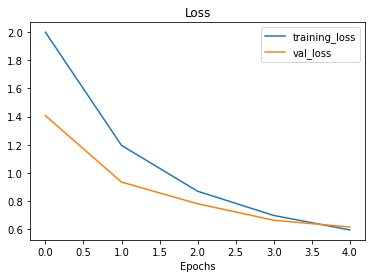

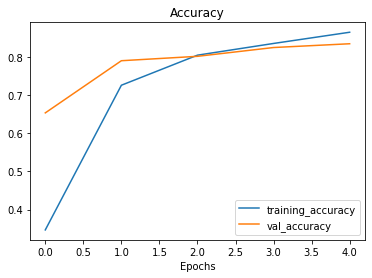

In [19]:
# Check out model's training curves
plot_loss_curves(history_10_percent)

Our model has given a good accuracy and if we train it for more epochs we might even get better accuracy.